In [1]:
import sys, os
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt

from units import *
from lensing_sim import LensingSim

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Fixed parameters

In [2]:
# Grid size
n_x, n_y = 52, 52
x_lims, y_lims = [-2, 2], [-2, 2]

# Host halo parameters
hst_param_dict = {'profile':'sis', 'theta_x':0.1, 'theta_y':-0.15, 'theta_E':1.}

# Observational parameters
observation_dict = {'nx':n_x, 'ny':n_y, 'xlims':x_lims, 'ylims':y_lims, 'exposure':(1/1.8e-19)*erg**-1*Centimeter**2*Angstrom*1000*Sec, 'A_iso':2e-7*erg/Centimeter**2/Sec/Angstrom/(radtoasc)**2}
global_dict = {'z_s':1.0, 'z_l':0.2}

# Source parameters
src_param_dict = {'profile':'sersic', 'I_gal':1e-17*erg/Centimeter**2/Sec/Angstrom,'theta_e_gal':0.5,'n_srsc':4}

In [5]:
# Minimal mass
m0 = 0.1

## Draw subhalo properties

In [6]:
def draw_subhalo_masses(alpha, beta, m0=m0):
    """
    Draws a varying number of subhalos together with their masses as a function
    of the power-law parameters alpha and beta.
    
    dn/dm = alpha m^{-beta}
    with alpha > 0, beta > 1
    """
    
    # Poisson mean
    nu = alpha / (beta - 1) * m0**(1. - beta)
    
    # Draw number of subhalos
    n = np.random.poisson(nu)
    
    # Draw masses for all subhalos
    u = np.random.uniform(0,1,size=n)
    #m = m0 * (1-u) ** (1/(beta+1))
    m = m0 * (1-u)**(1. / (-beta + 1.0))
    
    return n, m

In [49]:
ns, ms = [], []
all_ms = []
for i in range(100000):
    n, m = draw_subhalo_masses(1.0, 1.9, 0.1)
    ns.append(n)
    ms.append(m)
    all_ms += list(m)
    

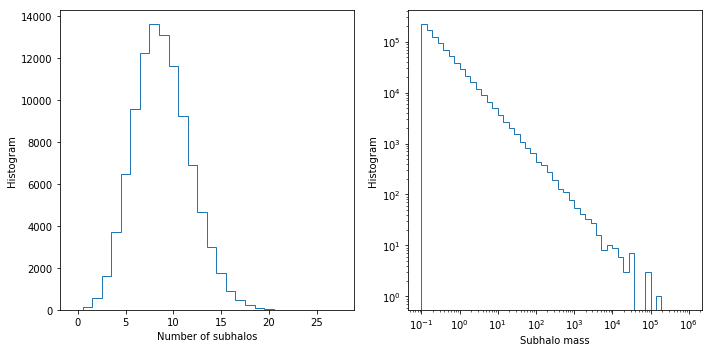

In [50]:
fig = plt.figure(figsize=(10,5))


ax = plt.subplot(1,2,1)

plt.hist(ns, bins=np.max(ns)+1, range=(-0.5,np.max(ns)+0.5), histtype='step')

#ax.set_yscale("log", nonposy='clip')
plt.xlabel(r'Number of subhalos')
plt.ylabel(r'Histogram')


ax = plt.subplot(1,2,2)

bins = 10**(np.linspace(-1, 6, 50))
plt.hist(all_ms, bins=bins, histtype='step')

ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')
plt.xlabel(r'Subhalo mass')
plt.ylabel(r'Histogram')

plt.tight_layout()
plt.show()

## Model parameters (old)

In [3]:
# Mean of Poisson distribution for number of subhalos
nu = 5.3

# "z" parameters
n = np.random.poisson(nu) # Number of subhalos
x_coords = np.random.uniform(low=x_lims[0], high=x_lims[1], size=n) # Subhalo coordinates
y_coords = np.random.uniform(low=y_lims[0], high=y_lims[1], size=n)

## Generate image

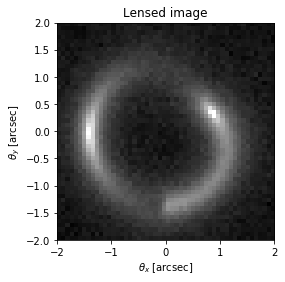

In [4]:
lens_list = [hst_param_dict]

# Substructure parameters
for isub in range(n):
    sub_param_dict = {'profile':'sis', 'theta_x':x_coords[isub], 'theta_y':y_coords[isub], 'theta_E':0.1}
    lens_list.append(sub_param_dict)

# Generate lensed image
LSI = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict)
i_tot = np.random.poisson((LSI.lensed_image()).numpy())

plt.imshow(np.log10(i_tot), vmax=3.5, cmap = 'gist_gray', extent=LSI.xlims+LSI.ylims, origin="lower")
plt.xlabel("$\\theta_x$ [arcsec]");
plt.ylabel("$\\theta_y$ [arcsec]");
plt.title('Lensed image');